## Dependencies

In [1]:
# Import dependencies
# NFL pbp data
import nfl_data_py as nfl

# Basics / visualizations
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Machine learning tools
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

# Stats Stuff
from scipy import stats
from scipy.stats import skew
import statsmodels.api as sm


# Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)

## Importing and Prepping Schedules

In [2]:
schedules_df = nfl.import_schedules([2024])

In [3]:
def get_upcoming_week(schedule):
    """
    Finds the nearest upcoming week where games have not yet been played.
    """
    # Filter out games where both home_score and away_score are NaN (future games)
    future_games = schedule[schedule['home_score'].isna() & schedule['away_score'].isna()]
    
    # Find the soonest week with future games
    upcoming_week = future_games['week'].min()
    
    return upcoming_week

In [4]:
get_upcoming_week(schedules_df)

5

In [5]:
schedules_df

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
6706,2024_01_BAL_KC,2024,REG,1,2024-09-05,Thursday,20:20,BAL,20.0,KC,27.0,Home,7.0,47.0,0.0,2024090500,59508,NaN,202409050kan,NaN,401671789,6449.0,7,7,124.0,-148.0,3.0,-118.0,-102.0,46.0,-110.0,-110.0,0,outdoors,grass,67.0,8.0,00-0034796,00-0033873,Lamar Jackson,Patrick Mahomes,John Harbaugh,Andy Reid,Shawn Hochuli,KAN00,GEHA Field at Arrowhead Stadium
6707,2024_01_GB_PHI,2024,REG,1,2024-09-06,Friday,20:15,GB,29.0,PHI,34.0,Neutral,5.0,63.0,0.0,2024090600,59509,NaN,202409060phi,NaN,401671805,6450.0,7,7,110.0,-130.0,2.0,-110.0,-110.0,49.5,-112.0,-108.0,0,outdoors,NaN,NaN,NaN,00-0036264,00-0036389,Jordan Love,Jalen Hurts,Matt LaFleur,Nick Sirianni,Ron Torbert,SAO00,Arena Corinthians
6708,2024_01_PIT_ATL,2024,REG,1,2024-09-08,Sunday,13:00,PIT,18.0,ATL,10.0,Home,-8.0,28.0,0.0,2024090800,59510,NaN,202409080atl,NaN,401671744,6451.0,7,7,160.0,-192.0,4.0,-110.0,-110.0,43.0,-115.0,-105.0,0,closed,fieldturf,NaN,NaN,00-0036945,00-0029604,Justin Fields,Kirk Cousins,Mike Tomlin,Raheem Morris,Brad Rogers,ATL97,Mercedes-Benz Stadium
6709,2024_01_ARI_BUF,2024,REG,1,2024-09-08,Sunday,13:00,ARI,28.0,BUF,34.0,Home,6.0,62.0,0.0,2024090801,59511,NaN,202409080buf,NaN,401671617,6452.0,7,7,250.0,-310.0,6.5,-105.0,-115.0,46.0,-112.0,-108.0,0,outdoors,a_turf,61.0,20.0,00-0035228,00-0034857,Kyler Murray,Josh Allen,Jonathan Gannon,Sean McDermott,Tra Blake,BUF00,New Era Field
6710,2024_01_TEN_CHI,2024,REG,1,2024-09-08,Sunday,13:00,TEN,17.0,CHI,24.0,Home,7.0,41.0,0.0,2024090802,59512,NaN,202409080chi,NaN,401671719,6453.0,7,7,164.0,-198.0,4.0,-108.0,-112.0,43.0,-110.0,-110.0,0,outdoors,grass,67.0,8.0,00-0039152,00-0039918,Will Levis,Caleb Williams,Brian Callahan,Matt Eberflus,Shawn Smith,CHI98,Soldier Field
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6973,2024_18_MIA_NYJ,2024,REG,18,2025-01-05,Sunday,13:00,MIA,NaN,NYJ,NaN,Home,NaN,NaN,NaN,2025010511,59775,NaN,202501050nyj,NaN,401671833,6716.0,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,outdoors,fieldturf,NaN,NaN,NaN,NaN,NaN,NaN,Mike McDaniel,Robert Saleh,NaN,NYC01,MetLife Stadium
6974,2024_18_NYG_PHI,2024,REG,18,2025-01-05,Sunday,13:00,NYG,NaN,PHI,NaN,Home,NaN,NaN,NaN,2025010512,59776,NaN,202501050phi,NaN,401671841,6717.0,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,Brian Daboll,Nick Sirianni,NaN,PHI00,Lincoln Financial Field
6975,2024_18_CIN_PIT,2024,REG,18,2025-01-05,Sunday,13:00,CIN,NaN,PIT,NaN,Home,NaN,NaN,NaN,2025010513,59777,NaN,202501050pit,NaN,401671836,6718.0,7,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,Zac Taylor,Mike Tomlin,NaN,PIT00,Acrisure Stadium
6976,2024_18_NO_TB,2024,REG,18,2025-01-05,Sunday,13:00,NO,NaN,TB,NaN,Home,NaN,NaN,NaN,2025010514,59778,NaN,202501050tam,NaN,401671828,6719.0,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,Dennis Allen,Todd Bowles,NaN,TAM00,Raymond James Stadium


## Importing PBP Data

In [54]:
# Select only the relevant columns
columns = ['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards', 
           'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
           'passing_yards', 'cpoe', 'roof', 'surface']

# Loading in the NFL pbp data
data = nfl.import_pbp_data(range(2014,2025), columns, include_participation=False)

# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
data = data[columns]

# Drop all rows that are not a pass
data = data[data['play_type'] == 'pass']

# Drop the play type column
passer_data = data.drop(columns=['play_type'])

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


## Passer DF Prep

In [144]:
# Group the data together by passer, week, season and aggregate
passer_df = passer_data.groupby(['game_id', 'passer_player_name', 'week', 'season'], as_index=False).agg(
    {'posteam' : 'first',
     'defteam' : 'first',
     'home_team' : 'first',
     'away_team' : 'first',
     'air_yards' : 'sum',
     'yards_after_catch' : 'sum',
     'epa' : 'sum',
     'complete_pass' : 'sum',
     'incomplete_pass' : 'sum',
     'interception' : 'sum',
     'qb_hit' : 'sum',
     'sack' : 'sum',
     'pass_touchdown' : 'sum',
     'passing_yards' : 'sum',
     'cpoe' : 'mean',
     'roof' : 'first',
     'surface' : 'first'
     }
)

# Create a new column that is completion percentage
passer_df['completion_percentage'] = passer_df['complete_pass'] / (passer_df['complete_pass'] + passer_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
passer_df['pass_attempts'] = passer_df['complete_pass'] + passer_df['incomplete_pass']

# # Drop the complete_pass and incomplete_pass columns
# passer_df = passer_df.drop(columns=['complete_pass', 'incomplete_pass'])

# Create a new column that equals 1 if the passer is the home team and 0 if the passer is the away team
passer_df['home_flag'] = passer_df['home_team'] == passer_df['posteam']

# # Drop the home_team and away_team columns
# passer_df = passer_df.drop(columns=['home_team', 'away_team'])

# Reorder the columns
passer_df = passer_df[['home_team', 'away_team', 'complete_pass', 'incomplete_pass' ,'game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'passing_yards', 'home_flag', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                        'cpoe', 'roof', 'surface']]

## Defense DF Prep

In [145]:
# Select only the relevant columns
defense_columns = ['defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards',
                   'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
                   'passing_yards', 'cpoe', 'roof', 'surface']


# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
defense_data = data[defense_columns]

# Drop the play type column
defense_data = defense_data.drop(columns=['play_type'])

# Group the data together by passer, week, season and aggregate
defense_df = defense_data.groupby(['defteam', 'week', 'season'], as_index=False).agg(
    {'home_team': 'first',
     'away_team': 'first',
     'air_yards': 'sum',
     'yards_after_catch': 'sum',
     'epa': 'sum',
     'complete_pass': 'sum',
     'incomplete_pass': 'sum',
     'interception': 'sum',
     'qb_hit': 'sum',
     'sack': 'sum',
     'pass_touchdown': 'sum',
     'passing_yards': 'sum',
     'cpoe': 'mean',
     'roof': 'first',
     'surface': 'first'
     }
)

# Create a new column that is completion percentage
defense_df['completion_percentage'] = defense_df['complete_pass'] / (defense_df['complete_pass'] + defense_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
defense_df['pass_attempts'] = defense_df['complete_pass'] + defense_df['incomplete_pass']

# # Drop the complete_pass and incomplete_pass columns
# defense_df = defense_df.drop(columns=['complete_pass', 'incomplete_pass'])

# Create a new column that equals 1 if the defense is the home team and 0 if the defense is the away team
defense_df['home_flag'] = defense_df['home_team'] == defense_df['defteam']

# # Drop the home_team and away_team columns
# defense_df = defense_df.drop(columns=['home_team', 'away_team'])

# Reorder the columns
defense_df = defense_df[['home_team', 'away_team', 'complete_pass', 'incomplete_pass', 'defteam', 'season', 'week', 'home_flag', 'passing_yards', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                       'cpoe', 'roof', 'surface']]

## Preprocessing

In [146]:
def calculate_offensive_ewma(passer_df):
    """
    Calculates EWMA for offensive columns using previous weeks' data, ensuring no leakage by excluding the current week.
    Takes into account multiple seasons.
    """
    # Sort by passer, season, and week
    passer_df = passer_df.sort_values(by=['passer_player_name', 'season', 'week'])

    # Calculate the exponentially weighted moving average for each offensive feature, excluding the current week
    passer_df['completion_percentage_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['completion_percentage']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['pass_attempts_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_attempts']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['air_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['air_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['yards_after_catch_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['yards_after_catch']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['epa_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['epa']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['interception_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['interception']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['qb_hit_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['qb_hit']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['sack_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['sack']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['pass_touchdown_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_touchdown']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['passing_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['passing_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['cpoe_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['cpoe']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    return passer_df

In [147]:
def pass_cleaner(passer_df):
    """
    Preps passer df for merging; drops unnecessary columns
    """
    passer_df.drop(columns=['home_team', 'away_team', 'complete_pass', 'incomplete_pass', 'completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'cpoe', 'home_team', 'away_team', 
                                    'complete_pass', 'incomplete_pass'], inplace=True)
    
    return passer_df

In [148]:
passer_emwa = calculate_offensive_ewma(passer_df)

In [149]:
passer_prepped = pass_cleaner(passer_emwa)

In [150]:
def calculate_defensive_ewma(defense_df):
    """
    Calculates EWMA for defensive columns using previous weeks' data (excluding the current week).
    """
    # Sort by 'defteam', 'season', and 'week' in ascending order (to ensure time order)
    defense_df = defense_df.sort_values(by=['defteam', 'season', 'week'])

    # Ensure proper grouping by both defteam and season
    defense_df['completion_percentage_ewma'] = defense_df.groupby(['defteam', 'season'])['completion_percentage']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())
    
    defense_df['pass_attempts_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_attempts']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['air_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['air_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['yards_after_catch_ewma'] = defense_df.groupby(['defteam', 'season'])['yards_after_catch']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['epa_ewma'] = defense_df.groupby(['defteam', 'season'])['epa']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['interception_ewma'] = defense_df.groupby(['defteam', 'season'])['interception']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['qb_hit_ewma'] = defense_df.groupby(['defteam', 'season'])['qb_hit']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['sack_ewma'] = defense_df.groupby(['defteam', 'season'])['sack']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['pass_touchdown_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_touchdown']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['passing_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['passing_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['cpoe_ewma'] = defense_df.groupby(['defteam', 'season'])['cpoe']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    return defense_df

In [151]:
def def_cleaner(defense_df):
    """
    Preps passer df for merging; drops unnecessary columns
    """
    # Drop the non-ewma columns
    defense_df.drop(columns=['passing_yards','completion_percentage',
                            'air_yards', 'yards_after_catch', 'epa',     
                            'interception', 'qb_hit', 'sack', 'pass_touchdown', 'pass_attempts', 'cpoe', 'complete_pass', 'incomplete_pass',
                            'home_team', 'away_team'
                            ], inplace=True)
    
    return defense_df

In [152]:
defense_ewma = calculate_defensive_ewma(defense_df)

In [153]:
defense_prepped = def_cleaner(defense_ewma)

In [154]:
# Merge the defense and passer dataframes together
full_with_ewma = passer_prepped.merge(defense_prepped, how='inner', on=['defteam', 'season', 'week', 'roof', 'surface'], suffixes=('_passer', '_defense'))

# Get rid of flukey rows
filtered_with_ewma = full_with_ewma[(full_with_ewma['pass_attempts'] > 8)]

#Ford Field is empty, you hate to see that
filtered_with_ewma['surface'].replace('', 'fieldturf', inplace=True)

C:\Users\bhugg\AppData\Local\Temp\ipykernel_10688\565364200.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_with_ewma['surface'].replace('', 'fieldturf', inplace=True)


## Week 1 is NaN's (duh, we use past weeks for EWMA's) for MVP I'll just get rid but for future seasons/rookies I do need a strategy

In [155]:
filtered_with_ewma = filtered_with_ewma.dropna()

In [156]:
# filtered_with_ewma[(filtered_with_ewma['season'] == 2024) & (filtered_with_ewma['week'] == 4)]

In [158]:
filtered_with_ewma.to_csv('forgpt.csv')

## Modeling

In [169]:
# Define the target and features
target = 'passing_yards'
features = filtered_with_ewma.columns.drop(['pass_attempts', 'passer_player_name', 'passing_yards', 'posteam', 'defteam', 'season', 'week', 'game_id'])

# Define categorical and numeric columns
categorical_columns = ['roof', 'surface']
numeric_columns = [col for col in features if col not in categorical_columns]

# Split the data into training (up to 2023) and testing (2024)
train_data = filtered_with_ewma[filtered_with_ewma['season'] <= 2023]
test_data = filtered_with_ewma[filtered_with_ewma['season'] == 2024]

# Separate features and target for both training and testing
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ])

# Apply the transformations to the training and test sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convert the transformed data into a LightGBM-compatible format
train_data_lgb = lgb.Dataset(X_train_transformed, label=y_train)
test_data_lgb = lgb.Dataset(X_test_transformed, label=y_test, reference=train_data_lgb)

# Set up the parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train the model with early stopping
lgb_model = lgb.train(params, train_data_lgb, valid_sets=[test_data_lgb], callbacks=[lgb.early_stopping(stopping_rounds=10)], num_boost_round=1000)

# Make predictions on the test set
y_pred = lgb_model.predict(X_test_transformed, num_iteration=lgb_model.best_iteration)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 69.6291
RMSE: 69.6291418133131


In [174]:
# Ensure test_data contains the 2024 season
test_data = filtered_with_ewma[filtered_with_ewma['season'] == 2024]

In [183]:
# Add predictions to the test_data (2024) DataFrame
test_data['predicted_passing_yards'] = y_pred

# Calculate whether the model over-predicted or under-predicted
test_data['pyoe'] = test_data['passing_yards'] - test_data['predicted_passing_yards']

# Display the updated dataframe with actual, predicted, and over/under information
test_data[['week', 'passer_player_name', 'passing_yards', 'predicted_passing_yards', 'pyoe']].sort_values(by='pyoe', ascending=False).head(50)

C:\Users\bhugg\AppData\Local\Temp\ipykernel_10688\4163454255.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_passing_yards'] = y_pred
C:\Users\bhugg\AppData\Local\Temp\ipykernel_10688\4163454255.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pyoe'] = test_data['passing_yards'] - test_data['predicted_passing_yards']


,week,passer_player_name,passing_yards,predicted_passing_yards,pyoe
4227,4,J.Love,389.0,234.137039,154.862961
187,3,A.Dalton,319.0,164.388956,154.611044
3235,4,G.Smith,395.0,251.167647,143.832353
1062,4,B.Mayfield,347.0,216.471364,130.528636
2102,3,C.Williams,363.0,240.827644,122.172356
3233,2,G.Smith,327.0,210.044420,116.955580
2839,3,D.Prescott,379.0,269.395123,109.604877
1188,2,B.Purdy,319.0,215.912490,103.087510
1965,4,C.Stroud,345.0,258.088442,86.911558
3514,3,J.Burrow,324.0,249.259788,74.740212


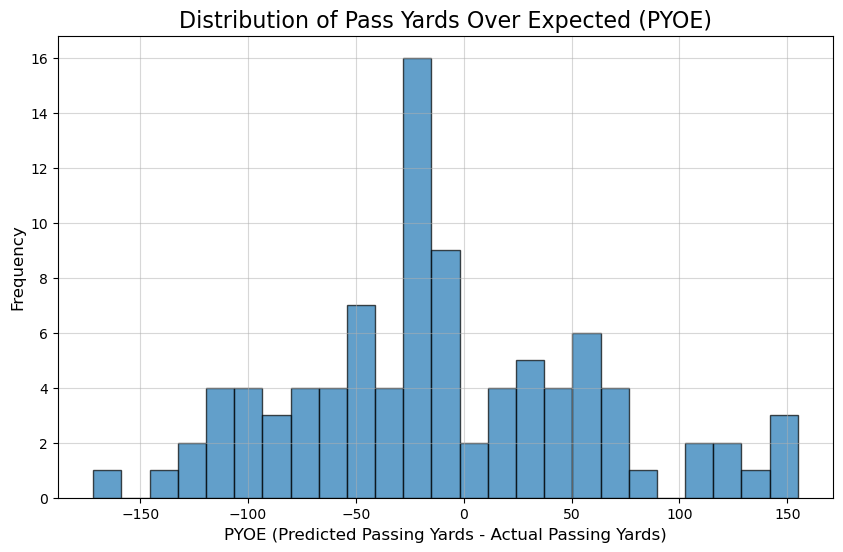

In [187]:
# Plotting the histogram of PYOE
plt.figure(figsize=(10, 6))
plt.hist(test_data['pyoe'], bins=25, edgecolor='black', alpha=0.7)
plt.title('Distribution of Pass Yards Over Expected (PYOE)', fontsize=16)
plt.xlabel('PYOE (Predicted Passing Yards - Actual Passing Yards)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()